# Import librerie

In [30]:
import tensorflow as tf
from numpy.lib import utils
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Preparazione dati


Lettura del dataset

In [25]:
df = pd.read_csv('/Users/raffaelerusso/Desktop/RO-progetto/Dataset/drawings.csv')
print("Dimensioni dataset: ",df.shape)
df.head(2)

Dimensioni dataset:  (5517, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Shuffle del dataset per velocizzare l'addestramento

In [8]:
df =  df.sample(frac=1, random_state=0)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
5250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


Estraggo le ground label dal dataset, corrispondenti all'ultima colonna del dataframe. Converto poi i dati in un formato adatto al modello in keras

In [26]:
labels = np.float32(df.pop('label'))
pics = np.float32(df.to_numpy())
pics = np.reshape(pics,(-1,28,28))

Visualizzazione immagini del dataset

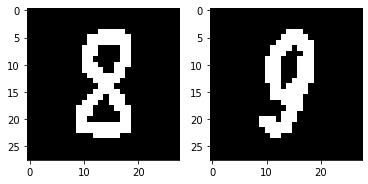

In [10]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pics[0],clim = [0,1],cmap = 'gray' )
plt.subplot(1,2,2)
plt.imshow(pics[1],clim = [0,1],cmap = 'gray' )


Suddivido il dataset in training set e test set <br />
Converto le etichette in formato categorical: 
$8 ⇒ [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]$

In [27]:
th = 4500
x_train = pics[0 : th]
x_test = pics[th :]

num_classes = 10

labels = keras.utils.to_categorical(labels,num_classes)
y_train = labels[0 : th]
y_test = labels[th :]

# Addestramento


Creazione della rete neurale convoluzionale

In [28]:
model = keras.Sequential([
        keras.Input(shape=(28,28,1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

Struttura modello e parametri

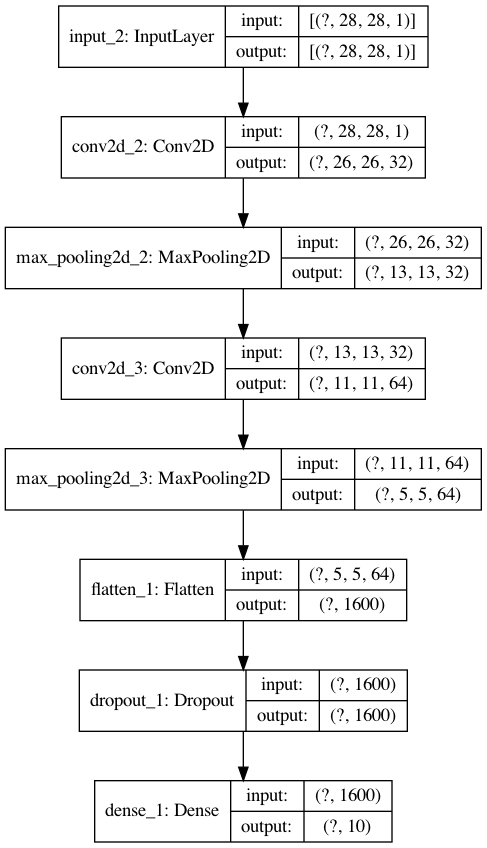

In [31]:
tf.keras.utils.plot_model(model, to_file='model.png',show_shapes = True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

Definizione callback per interrompere il training e ripristinare i pesi migliori del modello a seguito di overfitting sul validation set

In [15]:
callback = EarlyStopping(monitor = 'val_accuracy',restore_best_weights = True, patience = 10)

Compilazione del modello: si utilizza l'ottimizzatore Adam e come funzione costo la categorical_crossentropy: $$J(\theta) = - \sum_{i=1}^{classes}y_i log  \hat{y_i}$$

In [16]:
model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])

Adatto la dimensione di x_train e x_test al modello

In [17]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

Tuning dei parametri

In [18]:
EPOCHS = 20

history = model.fit(x_train,y_train,epochs = EPOCHS, validation_split = 0.1, verbose = True ,callbacks = [callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/20
4050/4050 [==============================] - 10s 2ms/sample - loss: 0.9911 - accuracy: 0.6835 - val_loss: 0.2424 - val_accuracy: 0.9356
Epoch 2/20
4050/4050 [==============================] - 9s 2ms/sample - loss: 0.2526 - accuracy: 0.9259 - val_loss: 0.1199 - val_accuracy: 0.9644
Epoch 3/20
4050/4050 [==============================] - 9s 2ms/sample - loss: 0.1454 - accuracy: 0.9553 - val_loss: 0.0808 - val_accuracy: 0.9800
Epoch 4/20
4050/4050 [==============================] - 9s 2ms/sample - loss: 0.1040 - accuracy: 0.9711 - val_loss: 0.0690 - val_accuracy: 0.9822
Epoch 5/20
4050/4050 [==============================] - 9s 2ms/sample - loss: 0.0840 - accuracy: 0.9760 - val_loss: 0.0726 - val_accuracy: 0.9756
Epoch 6/20
4050/4050 [==============================] - 9s 2ms/sample - loss: 0.0670 - accuracy: 0.9795 - val_loss: 0.0633 - val_accuracy: 0.9822
Epoch 7/20
4050/4050 [==============================] - 9s 2ms/sample - loss

# Valutazione modello

Andamento accuracy e loss function al variare delle epoche 

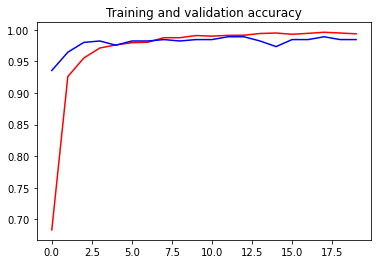

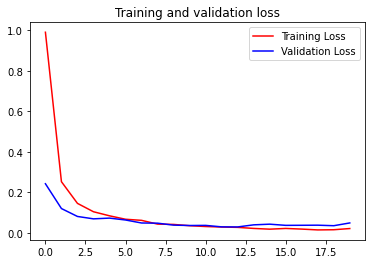

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Prestazioni del modello sul test set

In [20]:
result = model.evaluate(x_test,y_test)
test_acc = result[1]
test_loss = result[0]

print('test_acc : ',test_acc)
print('test_loss : ',test_loss)

1017/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Matrice di confusione

In [21]:
y_test_pred = np.argmax(model.predict(x_test), 1)
matrix = confusion_matrix(np.argmax(y_test,1), y_test_pred) 
print(matrix)

[[ 93   0   1   0   0   0   0   0   0   0]
 [  0  90   0   0   0   0   0   0   0   0]
 [  0   0 111   1   0   0   0   0   0   0]
 [  0   0   2  94   0   0   0   0   0   0]
 [  0   0   0   0  96   0   0   0   0   0]
 [  0   0   0   0   0  93   0   0   0   0]
 [  0   0   0   0   0   0  98   0   0   0]
 [  0   0   1   0   0   0   0 106   0   0]
 [  0   0   1   0   0   1   0   0 128   0]
 [  1   0   0   0   0   0   0   0   0 100]]


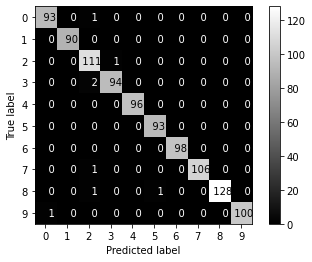

In [22]:
display = ConfusionMatrixDisplay(matrix)
display.plot(cmap = 'gray', values_format = '5')

Salvataggio modello e pesi

In [23]:
model.save('mnist_model.h5')
model.save_weights('mnist_weights.h5')